# Tutorial: Understanding MetaDynamics: Well Tempered MetaD

### Suggested reading:
- end of Belfast tutorial https://www.plumed.org/doc-v2.3/user-doc/html/belfast-6.html
- this video https://www.youtube.com/watch?v=bZZggbV2r5E


Hi!

In the original paper we defined DeltaT, in order to convey the message that the effective temperature of the CV is increased. Actually the CV is sampled as if it was at an effective temperature T'=T+DeltaT. In practice, this requires scaling the hills height with exp(-V/(k_BDeltaT))

However, in the plumed implementation we read the so-called bias factor, that was introduced in later papers, which tells you which factor you should multiply T to obtain T'. That is, T'=gamma*T.

Thus, gamma=(T+DeltaT)/T, and DeltaT=(gamma-1)*T. Hills height is scaled with exp(-V/(k_B*(gamma-1)*T))

gamma=1 (or DeltaT=0) implies unbiased sampling (hills become immediately infinitely small)

gamma=infinite (or DeltaT=infinite) implies non-welltempered metadynamics (no hills scaling)

Giovanni

In [41]:
!echo "MOLINFO MOLTYPE=protein STRUCTURE=init_box.pdb" >plumed_walkers.dat
!echo "phi33: TORSION ATOMS=@phi-33" >>plumed_walkers.dat
!echo "meta: METAD ARG=phi33 BIASFACTOR=10.0 TEMP=300.0 SIGMA=0.2 HEIGHT=1 PACE=100 FILE=HILLS_t1_02_1_100_WT_1ns.dat GRID_MIN=-pi GRID_MAX=pi WALKERS_MPI" >>plumed_walkers.dat
#The next line runs MD, takes a lot of time, and better should be run from a terminal, or even a Tmux terminal.
#!mpirun -np 4 mdrun_mpi -deffnm prod1ns_walkers -plumed plumed_walkers.dat -multi 4 #2> /dev/null 



Last Frame read : 501, time : 1000.0 ps
501 frame read in 0.09 seconds


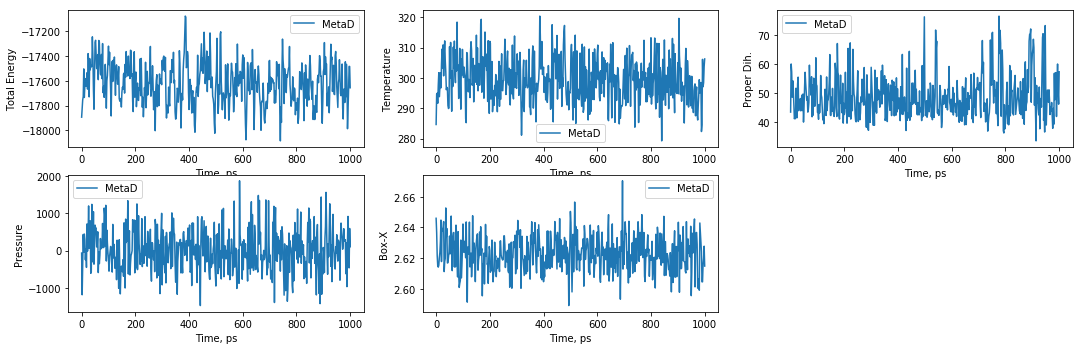

In [42]:
import panedr
from funcs import plot_plumed
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
df = panedr.edr_to_df('prod1ns_walkers0.edr', verbose=True)

num_of_keys=len(df.keys())
grid=[1+num_of_keys//3,3]

plt.figure(figsize=(grid[1]*6,grid[0]*3))
plt.title('Mod')
for i,key in enumerate(['Total Energy','Temperature','Proper Dih.','Pressure','Box-X'],1):
    ax=plt.subplot(*grid, i)
    ax.plot(df[key],label='MetaD')
    ax.set_xlabel('Time, ps')
    ax.set_ylabel(key)
    ax.legend()    
plt.show()

Labels found: ['time', 'phi33', 'sigma_phi33', 'height', 'biasf']


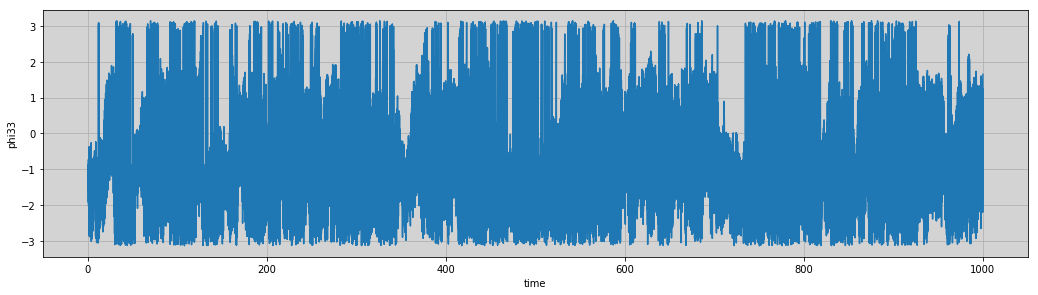

Labels found: ['time', 'phi33', 'sigma_phi33', 'height', 'biasf']


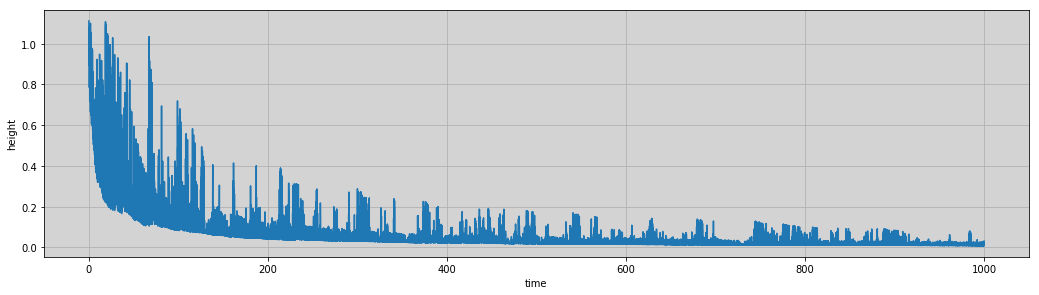

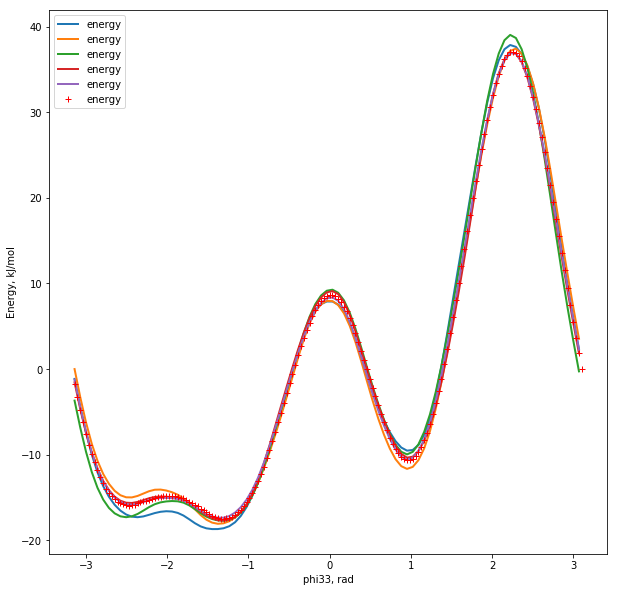

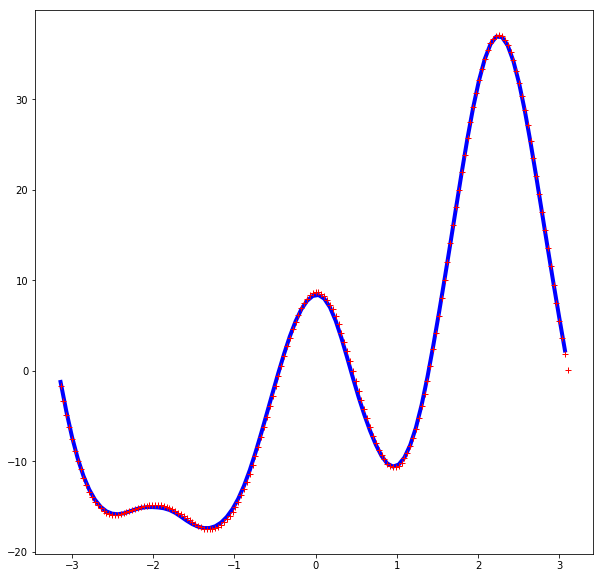

In [43]:
#Comparing what we get with the reference
from funcs import plot_plumed
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df_avr=pd.read_csv('reference_FEP_phi33.cvs',index_col=0)
df_avr

!mkdir -p big_data
!plumed sum_hills --stride 4000  --hills HILLS_t1_02_1_100_WT_1ns.dat --outfile big_data/sumhills_t1_02_1_100_WT_1ns.dat --mintozero >/dev/null
d=plot_plumed('HILLS_t1_02_1_100_WT_1ns.dat',figsize=(20,5),col2plot=[1]) 
d=plot_plumed('HILLS_t1_02_1_100_WT_1ns.dat',figsize=(20,5),col2plot=[3]) 



sum_df=pd.DataFrame()


plt.figure(figsize=(10,10))
for i in range(5):
    data=plot_plumed('big_data/sumhills_t1_02_1_100_WT_1ns.dat%d.dat'%i,plot=False,silent=True)
    df=pd.DataFrame({'angle':data[:,0],'energy':data[:,1]})
    #Remove average
    df['energy']=df['energy']-df['energy'].mean()
    df['Time']=i
    sum_df=pd.concat([sum_df,df])
#     plt.plot(df['angle'],df['energy'],linewidth=2,label='_nolegend_')
    plt.plot(df['angle'],df['energy'],linewidth=2)


plt.plot(df_avr['angle'],df_avr['energy']-df_avr['energy'].mean(),'r+',linewidth=3)
# plt.plot(df_avr['angle'],df_avr['energy']-df_avr['energy'].min(),'r+',linewidth=4)


plt.legend()
plt.xlabel('phi33, rad')
plt.ylabel('Energy, kJ/mol')
plt.figure(figsize=(10,10))
plt.plot(df['angle'],df['energy'],'b-',linewidth=4)
plt.plot(df_avr['angle'],df_avr['energy']-df_avr['energy'].mean(),'r+',linewidth=4)

df_avr_n=sum_df.loc[sum_df['Time']>150].groupby('angle', as_index=False).energy.mean()
plt.plot(df_avr_n['angle'],df_avr_n['energy']-df_avr_n['energy'].mean(),'g-',linewidth=3)




## Let's see what changes if we start with big height and use one walker

also use one walker

In [14]:
!echo "MOLINFO MOLTYPE=protein STRUCTURE=init_box.pdb" >plumed_walkers.dat
!echo "phi33: TORSION ATOMS=@phi-33" >>plumed_walkers.dat
!echo "meta: METAD ARG=phi33 BIASFACTOR=6.0 TEMP=300.0 SIGMA=0.2 HEIGHT=10 PACE=100 FILE=HILLS_t1_02_10_100_WT_1ns.dat GRID_MIN=-pi GRID_MAX=pi WALKERS_MPI" >>plumed_walkers.dat
#The next line runs MD, takes a lot of time, and better should be run from a terminal, or even a Tmux terminal.
#!mpirun -np 4 mdrun_mpi -deffnm prod1ns_walkers -plumed plumed_walkers.dat -multi 4 #2> /dev/null 
#!mpirun -np 1  mdrun_mpi -ntomp 10 -deffnm prod1ns_walkers1 -plumed plumed_walkers.dat 



Labels found: ['time', 'phi33', 'sigma_phi33', 'height', 'biasf']


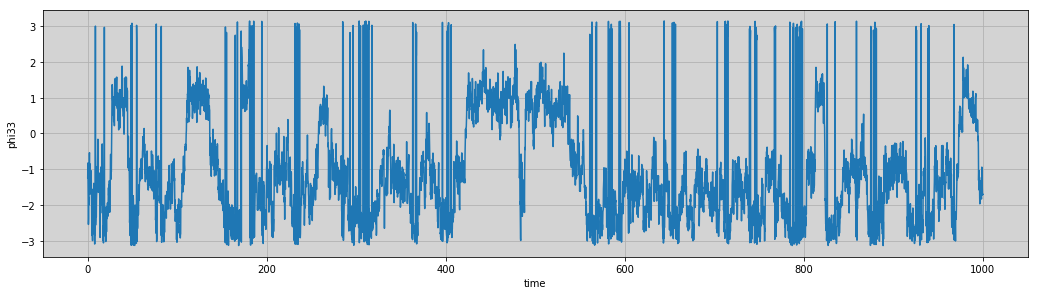

Labels found: ['time', 'phi33', 'sigma_phi33', 'height', 'biasf']


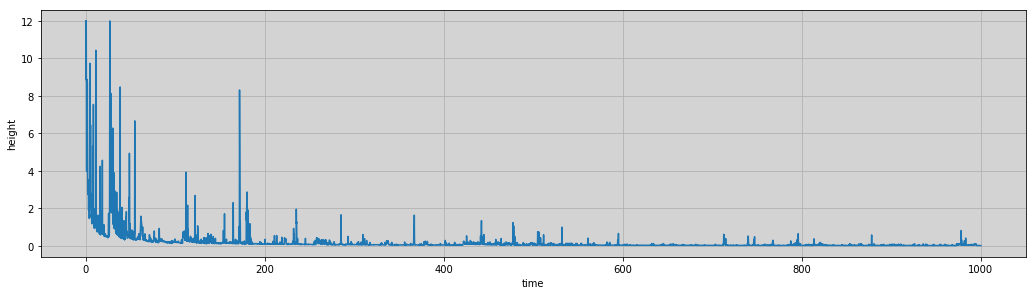

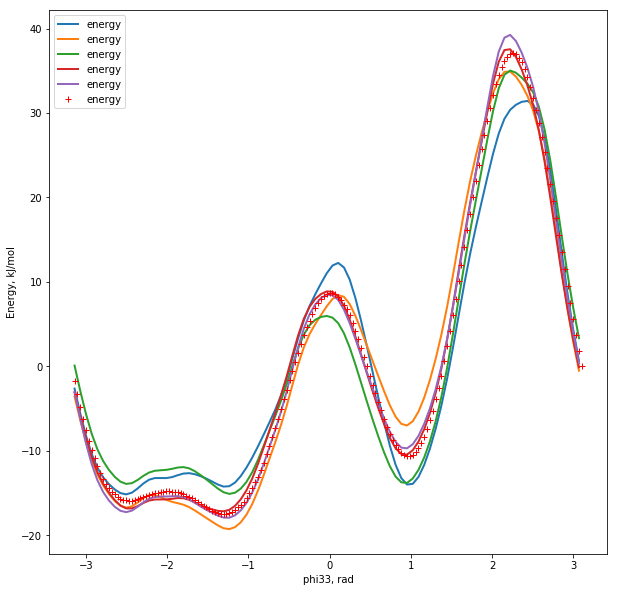

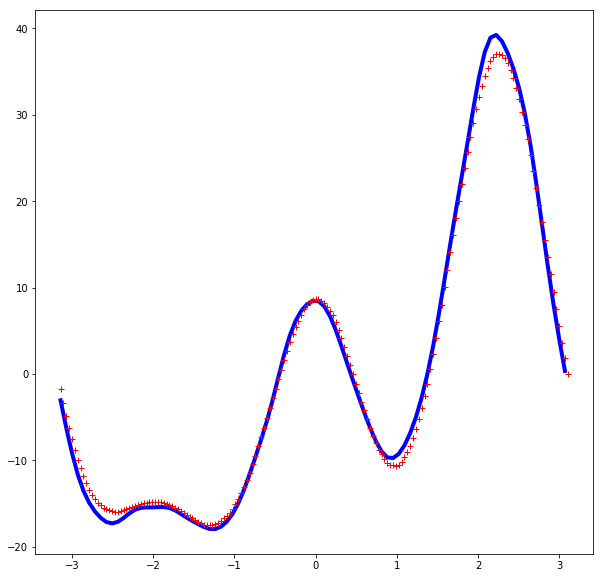

In [23]:
#Comparing what we get with the reference
from funcs import plot_plumed
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df_avr=pd.read_csv('reference_FEP_phi33.cvs',index_col=0)
df_avr

!mkdir -p big_data
!plumed sum_hills --stride 1000  --hills HILLS_t1_02_10_100_WT_1ns.dat --outfile big_data/sumhills_t1_02_10_100_WT_1ns.dat --mintozero >/dev/null
d=plot_plumed('HILLS_t1_02_10_100_WT_1ns.dat',figsize=(20,5),col2plot=[1]) 
d=plot_plumed('HILLS_t1_02_10_100_WT_1ns.dat',figsize=(20,5),col2plot=[3]) 



sum_df=pd.DataFrame()


plt.figure(figsize=(10,10))
for i in range(5):
    data=plot_plumed('big_data/sumhills_t1_02_10_100_WT_1ns.dat%d.dat'%i,plot=False,silent=True)
    df=pd.DataFrame({'angle':data[:,0],'energy':data[:,1]})
    #Remove average
    df['energy']=df['energy']-df['energy'].mean()
    df['Time']=i
    sum_df=pd.concat([sum_df,df])
#     plt.plot(df['angle'],df['energy'],linewidth=2,label='_nolegend_')
    plt.plot(df['angle'],df['energy'],linewidth=2)


plt.plot(df_avr['angle'],df_avr['energy']-df_avr['energy'].mean(),'r+',linewidth=3)
# plt.plot(df_avr['angle'],df_avr['energy']-df_avr['energy'].min(),'r+',linewidth=4)


plt.legend()
plt.xlabel('phi33, rad')
plt.ylabel('Energy, kJ/mol')
plt.figure(figsize=(10,10))
plt.plot(df['angle'],df['energy'],'b-',linewidth=4)
plt.plot(df_avr['angle'],df_avr['energy']-df_avr['energy'].mean(),'r+',linewidth=4)

df_avr_n=sum_df.loc[sum_df['Time']>150].groupby('angle', as_index=False).energy.mean()
plt.plot(df_avr_n['angle'],df_avr_n['energy']-df_avr_n['energy'].mean(),'g-',linewidth=3)




## Let's see what changes if we use small bias 2

also use one walker

In [30]:
!echo "MOLINFO MOLTYPE=protein STRUCTURE=init_box.pdb" >plumed_walkers.dat
!echo "phi33: TORSION ATOMS=@phi-33" >>plumed_walkers.dat
!echo "meta: METAD ARG=phi33 BIASFACTOR=2 TEMP=300.0 SIGMA=0.2 HEIGHT=10 PACE=100 FILE=HILLS_t1_02_10_100_WT_1ns_b2.dat GRID_MIN=-pi GRID_MAX=pi WALKERS_MPI" >>plumed_walkers.dat
#The next line runs MD, takes a lot of time, and better should be run from a terminal, or even a Tmux terminal.
#!mpirun -np 4 mdrun_mpi -deffnm prod1ns_walkers -plumed plumed_walkers.dat -multi 4 #2> /dev/null 
#!mpirun -np 1  mdrun_mpi -ntomp 10 -deffnm prod1ns_walkers1 -plumed plumed_walkers.dat 



Labels found: ['time', 'phi33', 'sigma_phi33', 'height', 'biasf']


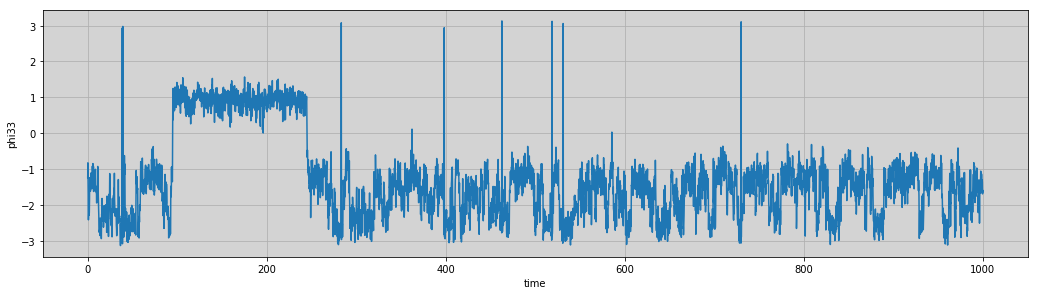

Labels found: ['time', 'phi33', 'sigma_phi33', 'height', 'biasf']


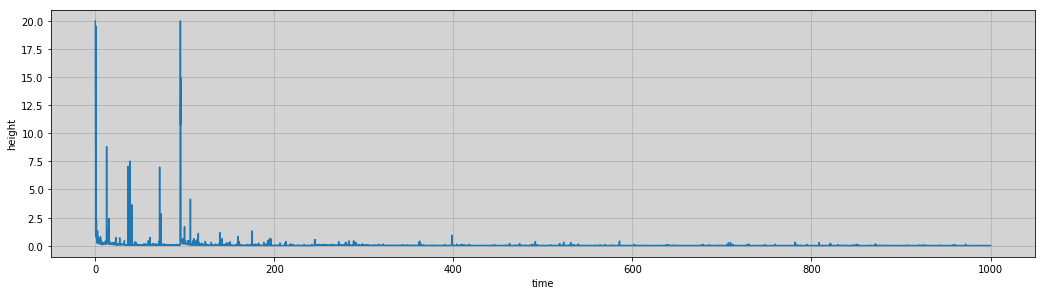

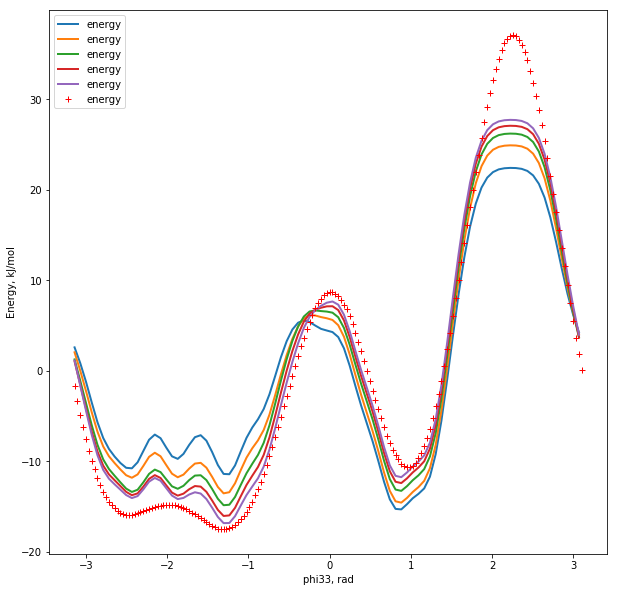

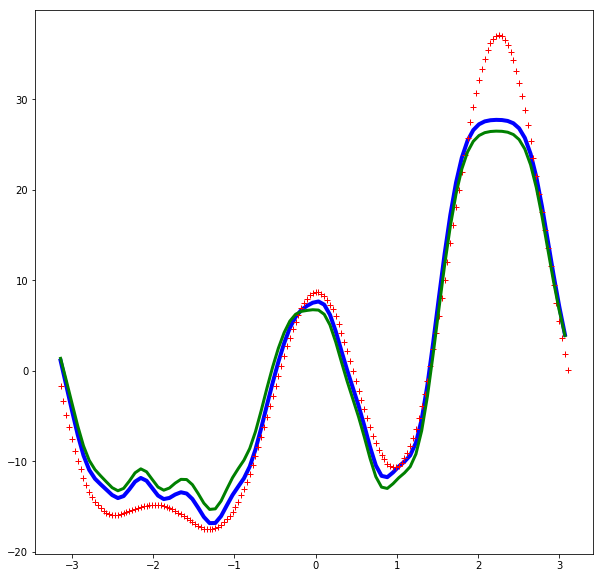

In [31]:
#Comparing what we get with the reference
from funcs import plot_plumed
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df_avr=pd.read_csv('reference_FEP_phi33.cvs',index_col=0)
df_avr

!mkdir -p big_data
!plumed sum_hills --stride 1000  --hills HILLS_t1_02_10_100_WT_1ns_b2.dat --outfile big_data/sumhills_t1_02_10_100_WT_1ns_b2.dat --mintozero >/dev/null
d=plot_plumed('HILLS_t1_02_10_100_WT_1ns_b2.dat',figsize=(20,5),col2plot=[1]) 
d=plot_plumed('HILLS_t1_02_10_100_WT_1ns_b2.dat',figsize=(20,5),col2plot=[3]) 



sum_df=pd.DataFrame()


plt.figure(figsize=(10,10))
for i in range(5):
    data=plot_plumed('big_data/sumhills_t1_02_10_100_WT_1ns_b2.dat%d.dat'%i,plot=False,silent=True)
    df=pd.DataFrame({'angle':data[:,0],'energy':data[:,1]})
    #Remove average
    df['energy']=df['energy']-df['energy'].mean()
    df['Time']=i
    sum_df=pd.concat([sum_df,df])
#     plt.plot(df['angle'],df['energy'],linewidth=2,label='_nolegend_')
    plt.plot(df['angle'],df['energy'],linewidth=2)


plt.plot(df_avr['angle'],df_avr['energy']-df_avr['energy'].mean(),'r+',linewidth=3)
# plt.plot(df_avr['angle'],df_avr['energy']-df_avr['energy'].min(),'r+',linewidth=4)


plt.legend()
plt.xlabel('phi33, rad')
plt.ylabel('Energy, kJ/mol')
plt.figure(figsize=(10,10))
plt.plot(df['angle'],df['energy'],'b-',linewidth=4)
plt.plot(df_avr['angle'],df_avr['energy']-df_avr['energy'].mean(),'r+',linewidth=4)

df_avr_n=sum_df.loc[sum_df['Time']>0].groupby('angle', as_index=False).energy.mean()
plt.plot(df_avr_n['angle'],df_avr_n['energy']-df_avr_n['energy'].mean(),'g-',linewidth=3)




## Let's see what changes if we use small bias 1.5

also use one walker

In [32]:
!echo "MOLINFO MOLTYPE=protein STRUCTURE=init_box.pdb" >plumed_walkers.dat
!echo "phi33: TORSION ATOMS=@phi-33" >>plumed_walkers.dat
!echo "meta: METAD ARG=phi33 BIASFACTOR=1.5 TEMP=300.0 SIGMA=0.2 HEIGHT=10 PACE=100 FILE=HILLS_t1_02_10_100_WT_1ns_b1.5.dat GRID_MIN=-pi GRID_MAX=pi WALKERS_MPI" >>plumed_walkers.dat
#The next line runs MD, takes a lot of time, and better should be run from a terminal, or even a Tmux terminal.
#!mpirun -np 4 mdrun_mpi -deffnm prod1ns_walkers -plumed plumed_walkers.dat -multi 4 #2> /dev/null 
#!mpirun -np 1  mdrun_mpi -ntomp 10 -deffnm prod1ns_walkers1 -plumed plumed_walkers.dat 



Labels found: ['time', 'phi33', 'sigma_phi33', 'height', 'biasf']


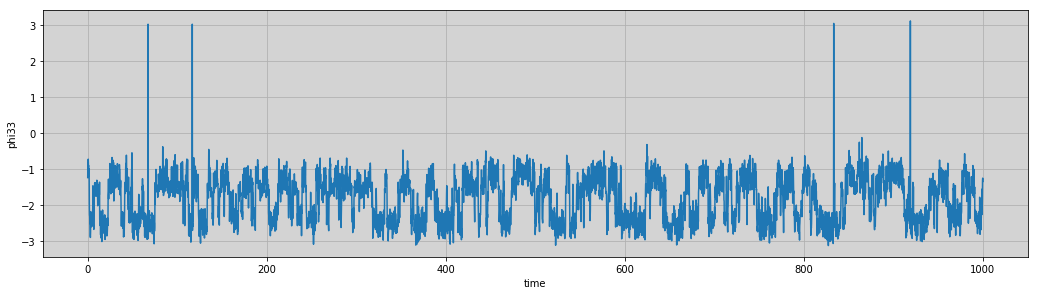

Labels found: ['time', 'phi33', 'sigma_phi33', 'height', 'biasf']


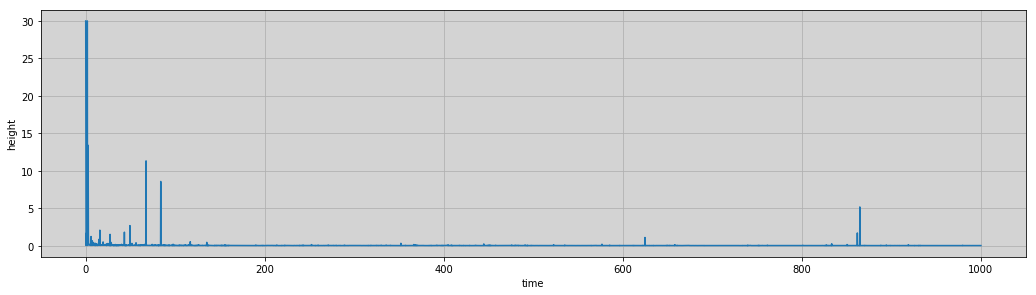

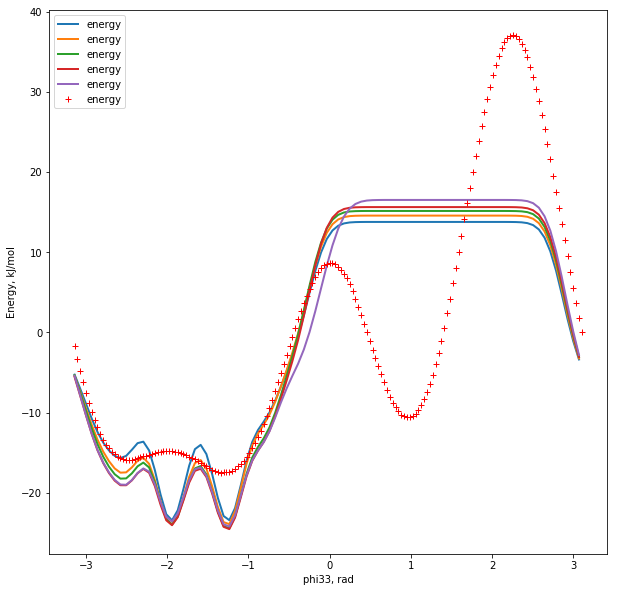

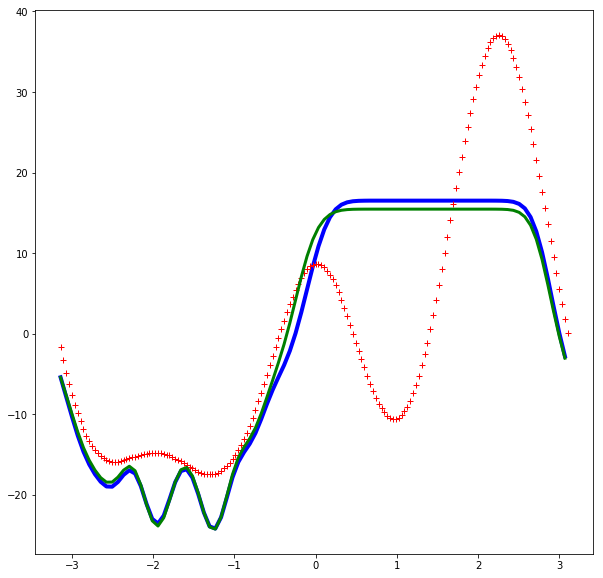

In [33]:
#Comparing what we get with the reference
from funcs import plot_plumed
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df_avr=pd.read_csv('reference_FEP_phi33.cvs',index_col=0)
df_avr

!mkdir -p big_data
!plumed sum_hills --stride 1000  --hills HILLS_t1_02_10_100_WT_1ns_b1.5.dat --outfile big_data/sumhills_t1_02_10_100_WT_1ns_b1.5.dat --mintozero >/dev/null
d=plot_plumed('HILLS_t1_02_10_100_WT_1ns_b1.5.dat',figsize=(20,5),col2plot=[1]) 
d=plot_plumed('HILLS_t1_02_10_100_WT_1ns_b1.5.dat',figsize=(20,5),col2plot=[3]) 



sum_df=pd.DataFrame()


plt.figure(figsize=(10,10))
for i in range(5):
    data=plot_plumed('big_data/sumhills_t1_02_10_100_WT_1ns_b1.5.dat%d.dat'%i,plot=False,silent=True)
    df=pd.DataFrame({'angle':data[:,0],'energy':data[:,1]})
    #Remove average
    df['energy']=df['energy']-df['energy'].mean()
    df['Time']=i
    sum_df=pd.concat([sum_df,df])
#     plt.plot(df['angle'],df['energy'],linewidth=2,label='_nolegend_')
    plt.plot(df['angle'],df['energy'],linewidth=2)


plt.plot(df_avr['angle'],df_avr['energy']-df_avr['energy'].mean(),'r+',linewidth=3)
# plt.plot(df_avr['angle'],df_avr['energy']-df_avr['energy'].min(),'r+',linewidth=4)


plt.legend()
plt.xlabel('phi33, rad')
plt.ylabel('Energy, kJ/mol')
plt.figure(figsize=(10,10))
plt.plot(df['angle'],df['energy'],'b-',linewidth=4)
plt.plot(df_avr['angle'],df_avr['energy']-df_avr['energy'].mean(),'r+',linewidth=4)

df_avr_n=sum_df.loc[sum_df['Time']>0].groupby('angle', as_index=False).energy.mean()
plt.plot(df_avr_n['angle'],df_avr_n['energy']-df_avr_n['energy'].mean(),'g-',linewidth=3)




We are getting bigger barriers and false minima !!! That important to understand.

## Let's see if sutuation impoves with longer runs, use 4 walkers

In [34]:
!echo "MOLINFO MOLTYPE=protein STRUCTURE=init_box.pdb" >plumed_walkers.dat
!echo "phi33: TORSION ATOMS=@phi-33" >>plumed_walkers.dat
!echo "meta: METAD ARG=phi33 BIASFACTOR=2 TEMP=300.0 SIGMA=0.2 HEIGHT=10 PACE=100 FILE=HILLS_t1_02_10_100_WT_1ns_b2.dat GRID_MIN=-pi GRID_MAX=pi WALKERS_MPI" >>plumed_walkers.dat
#The next line runs MD, takes a lot of time, and better should be run from a terminal, or even a Tmux terminal.
#!mpirun -np 4 mdrun_mpi -deffnm prod1ns_walkers -plumed plumed_walkers.dat -multi 4 #2> /dev/null 



Labels found: ['time', 'phi33', 'sigma_phi33', 'height', 'biasf']


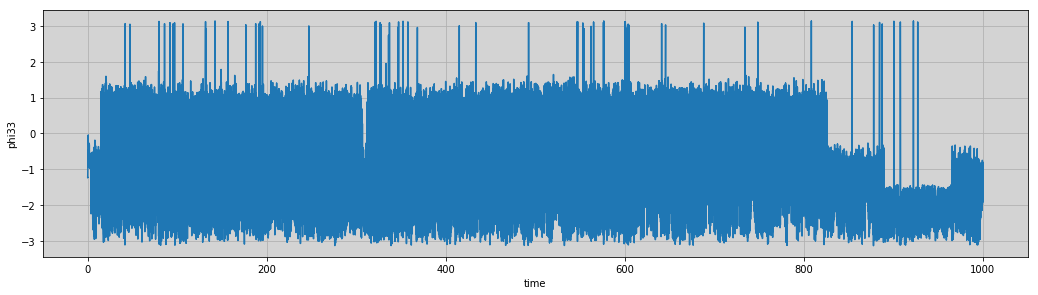

Labels found: ['time', 'phi33', 'sigma_phi33', 'height', 'biasf']


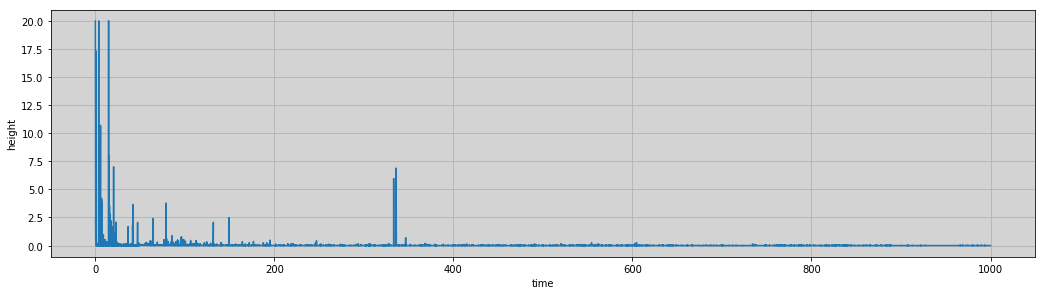

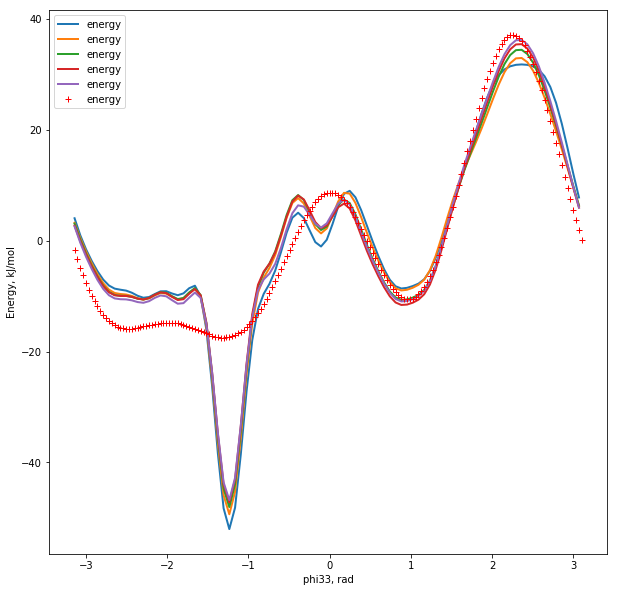

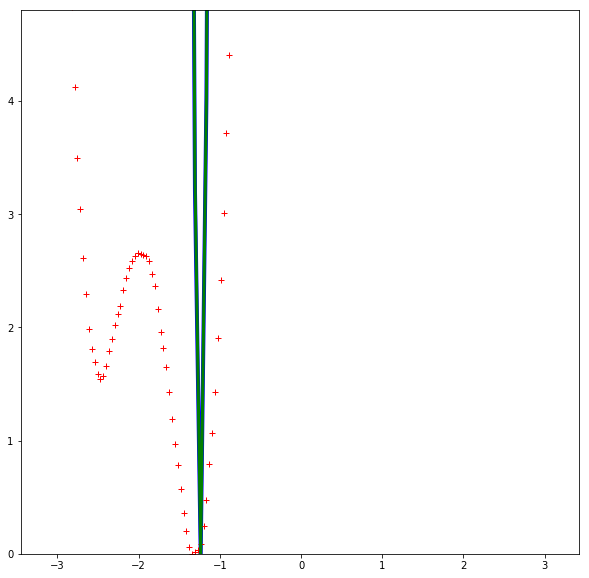

In [40]:
#Comparing what we get with the reference
from funcs import plot_plumed
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df_avr=pd.read_csv('reference_FEP_phi33.cvs',index_col=0)
df_avr

!mkdir -p big_data
!plumed sum_hills --stride 4000  --hills HILLS_t1_02_10_100_WT_1ns_b2.dat --outfile big_data/sumhills_t1_02_10_100_WT_1ns_b2.dat --mintozero >/dev/null
d=plot_plumed('HILLS_t1_02_10_100_WT_1ns_b2.dat',figsize=(20,5),col2plot=[1]) 
d=plot_plumed('HILLS_t1_02_10_100_WT_1ns_b2.dat',figsize=(20,5),col2plot=[3]) 



sum_df=pd.DataFrame()


plt.figure(figsize=(10,10))
for i in range(5):
    data=plot_plumed('big_data/sumhills_t1_02_10_100_WT_1ns_b2.dat%d.dat'%i,plot=False,silent=True)
    df=pd.DataFrame({'angle':data[:,0],'energy':data[:,1]})
    #Remove average
    df['energy']=df['energy']-df['energy'].mean()
    df['Time']=i
    sum_df=pd.concat([sum_df,df])
#     plt.plot(df['angle'],df['energy'],linewidth=2,label='_nolegend_')
    plt.plot(df['angle'],df['energy'],linewidth=2)


plt.plot(df_avr['angle'],df_avr['energy']-df_avr['energy'].mean(),'r+',linewidth=3)
# plt.plot(df_avr['angle'],df_avr['energy']-df_avr['energy'].min(),'r+',linewidth=4)


plt.legend()
plt.xlabel('phi33, rad')
plt.ylabel('Energy, kJ/mol')
plt.figure(figsize=(10,10))
plt.ylim(0,2*2.4)
plt.plot(df['angle'],df['energy']-df['energy'].min(),'b-',linewidth=4)
plt.plot(df_avr['angle'],df_avr['energy']-df_avr['energy'].min(),'r+',linewidth=4)

df_avr_n=sum_df.loc[sum_df['Time']>0].groupby('angle', as_index=False).energy.mean()
plt.plot(df_avr_n['angle'],df_avr_n['energy']-df_avr_n['energy'].min(),'g-',linewidth=3)




In [ ]:
Conclusion - low bias causes problems in sampling.
Another possibility is that we are getting some oscilations without solvent.